In [1]:
#setup notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%matplotlib notebook
%autosave 0

import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

import os
import sys
import numpy as np
import pandas as pd
import gmsh_api
import gmsh_api.gmsh as gmsh
print("gmsh_api package: v{}".format(gmsh_api.__version__))
print("GMSH_API_VERSION: v{}".format(gmsh.GMSH_API_VERSION))

Autosave disabled
gmsh_api package: v0.1.4
GMSH_API_VERSION: v4.2


In [2]:
gmsh.initialize()

gmsh.option.setNumber("General.Terminal", 1)
gmsh.option.setNumber("Mesh.Algorithm", 5) # delquad
gmsh.option.setNumber("Mesh.RecombineAll", 1)

gmsh.model.add("square")
gmsh.model.geo.addPoint(0, 0, 0, 0.6, 1)
gmsh.model.geo.addPoint(1, 0, 0, 0.6, 2)
gmsh.model.geo.addPoint(1, 1, 0, 0.5, 3)
gmsh.model.geo.addPoint(0, 1, 0, 0.4, 4)
gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 3, 2)
gmsh.model.geo.addLine(3, 4, 3)
# try automatic assignement of tag
line4 = gmsh.model.geo.addLine(4, 1)
gmsh.model.geo.addCurveLoop([1, 2, 3, line4], 1)
gmsh.model.geo.addPlaneSurface([1], 6)
gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)
gmsh.write("square.unv")


In [3]:
msh = gmsh_api.Mesh.from_gmsh(gmsh)
msh

(Mesh nodes:10 elements:17)

In [4]:
msh.nodes

,nid,x,y,z
nid,,,,
1,1,0.000000,0.000000,0.0
2,2,1.000000,0.000000,0.0
3,3,1.000000,1.000000,0.0
4,4,0.000000,1.000000,0.0
5,5,0.500000,0.000000,0.0
6,6,1.000000,0.522774,0.0
7,7,0.728708,1.000000,0.0
8,8,0.472136,1.000000,0.0
9,9,0.229485,1.000000,0.0


In [5]:
msh.elements

,pid,elid,type,n_nodes,nodes,nidxs
0,1,17,shell4,4,"[9, 16, 14, 8]","[9, 16, 14, 8]"
1,1,18,shell4,4,"[14, 16, 10, 11]","[14, 16, 10, 11]"
2,1,19,shell4,4,"[10, 16, 9, 4]","[10, 16, 9, 4]"
3,1,20,shell4,4,"[5, 15, 14, 13]","[5, 15, 14, 13]"
4,1,21,shell4,4,"[6, 17, 14, 15]","[6, 17, 14, 15]"
5,1,22,shell4,4,"[6, 15, 5, 2]","[6, 15, 5, 2]"
6,1,23,shell4,4,"[14, 17, 7, 8]","[14, 17, 7, 8]"
7,1,24,shell4,4,"[14, 11, 12, 13]","[14, 11, 12, 13]"
8,1,25,shell4,4,"[5, 13, 12, 1]","[5, 13, 12, 1]"
9,1,26,shell4,4,"[6, 3, 7, 17]","[6, 3, 7, 17]"


In [6]:
from scale.fem.lsdyna import api
mesh = api.Mesh(name="gmsh")
mesh.nodes = msh.nodes
mesh.elements = msh.elements
mesh.nodes.z = mesh.nodes.x + mesh.nodes.y
mesh.info()


12:16:29 INFO:nodes: 17
12:16:29 INFO:elements: 10


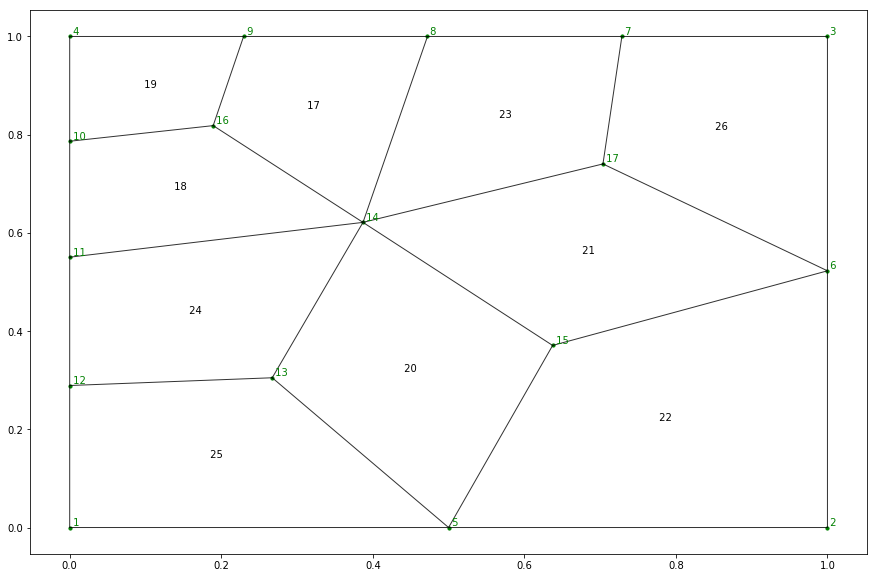

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(15, 10))
mesh.plot_mpl(ax, elid=1, node=1, nid=1)

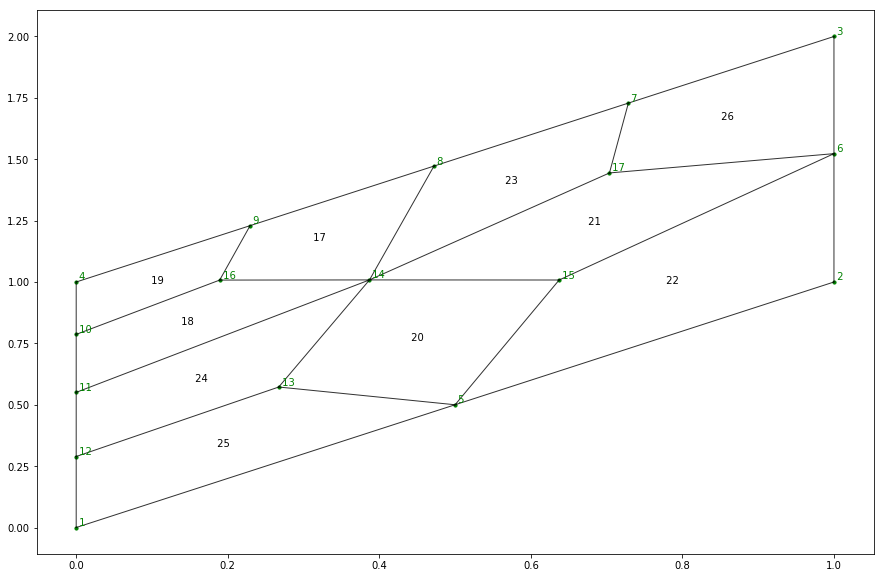

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(15, 10))
mesh.plot_mpl(ax, elid=1, node=1, nid=1, x=1, y=0, z=1)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(15, 10))
mesh.plot_mpl(ax, elid=1, node=1, nid=1, x=0, y=1, z=1)

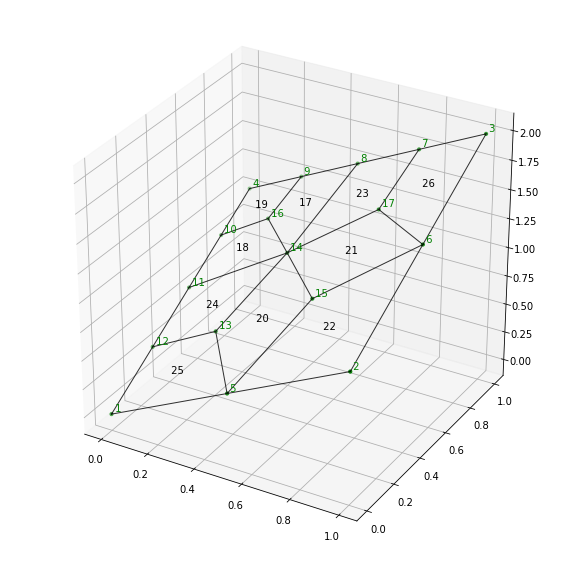

In [17]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
mesh.plot_mpl(ax, elid=1, node=1, nid=1, x=1, y=1, z=1)

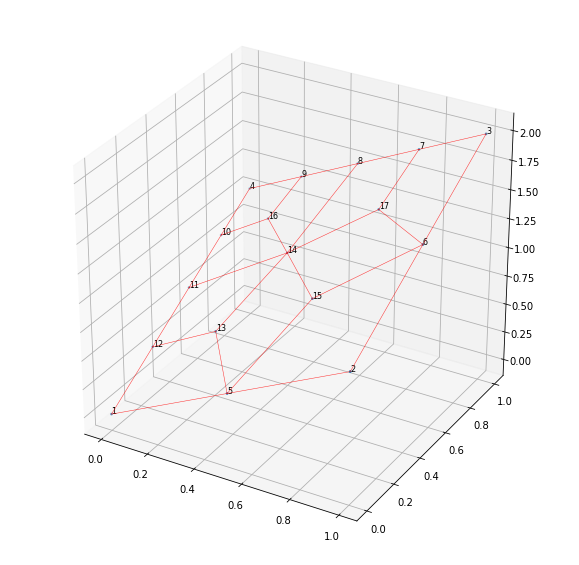

In [10]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
x,y,z = mesh.get_all_edges_mpl_data()
ax.plot(x, y, z, lw=.5, c="r", alpha=.8)

ax.scatter(mesh.nodes.x, mesh.nodes.y, mesh.nodes.z, s=3)
for i, n in mesh.nodes.iterrows():
    ax.text(n.x,n.y,n.z,  '%s' % (int(n.nid)), size=8, zorder=1, color='k')

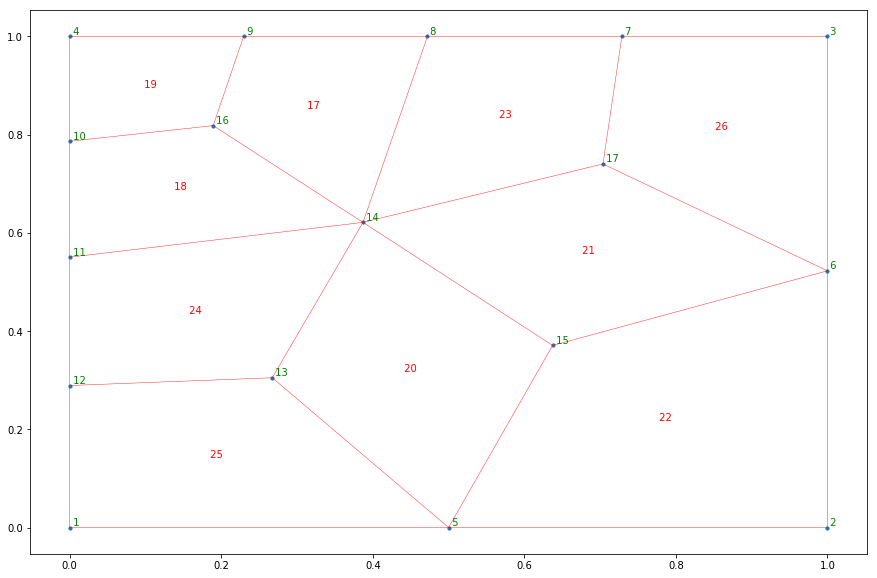

In [11]:

contour = mesh.get_unique_edges()
counturnodes = mesh.nodes.loc[contour[["ne", "nb"]].values.ravel()]
x,y,z = mesh.get_all_edges_mpl_data()
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.plot(x, y, lw=.5, c="r", alpha=.8)
ax.scatter(mesh.nodes.x, mesh.nodes.y, s=10)
for i, n in mesh.nodes.iterrows():
    ax.text(n.x,n.y,' %s' % (int(n.nid)), color='g', ha="left", va="bottom")
elc = mesh.calc_center()
for i, n in elc.iterrows():
    ax.text(n.center_x,n.center_y,' %s' % (int(n.name)), ha="center", va="center", color="r")


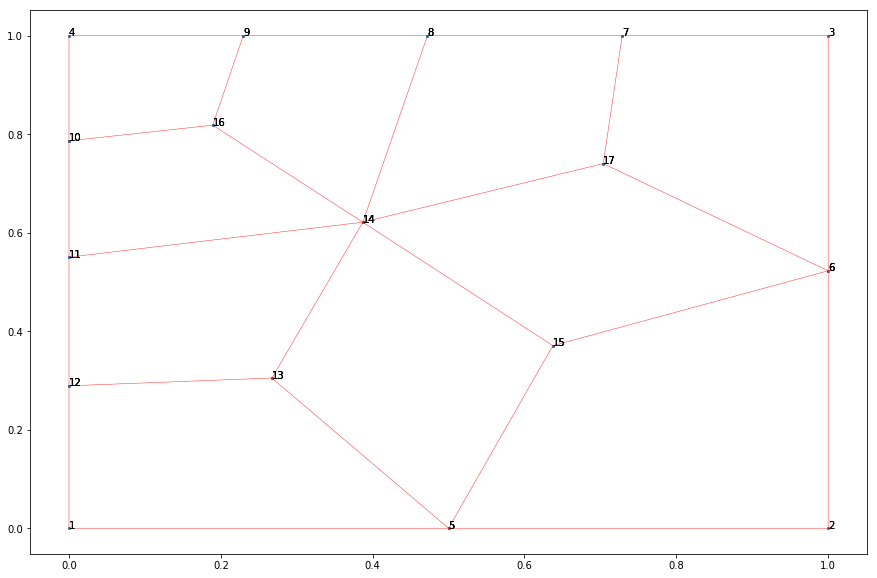

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
contour = mesh.get_unique_edges(size=[1,3])
counturnodes = mesh.nodes.loc[contour[["ne", "nb"]].values.ravel()]
x,y,z = mesh.get_unique_edges_mpl_data(size=[1,3])
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.plot(x, y, lw=.5, c="r", alpha=.8)
ax.scatter(counturnodes.x, counturnodes.y, s=3)
for i, n in mesh.nodes.loc[contour[["ne", "nb"]].values.ravel()].iterrows():
    ax.text(n.x,n.y,'%s' % (int(n.nid)), color='k')

In [13]:
mesh.__class__

scale.fem.mesh.Mesh

In [14]:
#gmsh.fltk.run()
#gmsh.finalize()
